"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [2]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

In [189]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

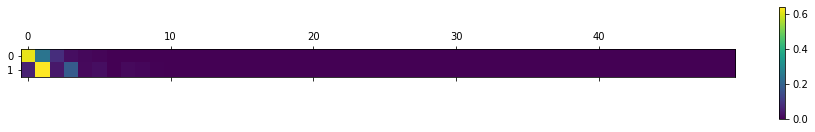

In [280]:
import scipy as sp
N = 2
K = 50
alpha = 1
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
plt.matshow(w); plt.colorbar()

In [281]:
# lens = w[0]
# lens = lens / lens.sum()
# changes = np.cumsum(lens)
# rate = np.random.random(len(lens)-1)
# total_len = 100
# fin_changes = np.vectorize(np.int)(total_len * changes)
# x = np.zeros(total_len)
# for num, this_rate in enumerate(rate):
#     x[fin_changes[num]:fin_changes[num+1]] = this_rate
# plt.plot(x)

In [282]:
lens = w[0]
lens = lens / lens.sum()
changes = np.cumsum(lens)
total_len = 100
fin_changes = np.vectorize(np.int)(total_len * changes)
fin_changes

array([61, 86, 94, 97, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
       99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
       99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99])

In [309]:
fin_changes[:3] = [33,66,99]
fin_changes[3:] = 100
fin_changes

array([ 33,  66,  99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

In [310]:
length = total_len
idx = np.arange(length)

with pm.Model() as dpp_model:
    
    #a_lambda = 2
    #b_lambda = 5
    #lambda_latent = pm.Beta('lambda_latent', a_lambda, b_lambda, shape = K+1)  
    #lambda_latent = pm.HalfNormal('lambda_latent', 1, shape = K)
    
    
    #alpha = pm.HalfCauchy('alpha',5)
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape = K)
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * total_len))
    
    obs = pm.Normal('obs', mu = tau, sigma = 10, observed = fin_changes)
    
    #     weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    #     weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    #     inverse_stack = 1 - weight_stack[1:]
    #     inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    #     weight_stack = np.multiply(weight_stack,inverse_stack)

    #     lambda_ = pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0)
    #     # Add observations
    #     observation = pm.Normal("obs", mu = lambda_, sigma = 1, observed=x)

In [311]:
with dpp_model:
    spp = pm.sample_prior_predictive(samples = 100)

(array([49., 16., 15.,  8.,  3.,  4.,  2.,  2.,  0.,  1.]),
 array([0.01546715, 0.4747077 , 0.93394825, 1.3931888 , 1.85242935,
        2.31166989, 2.77091044, 3.23015099, 3.68939154, 4.14863209,
        4.60787263]),
 <BarContainer object of 10 artists>)

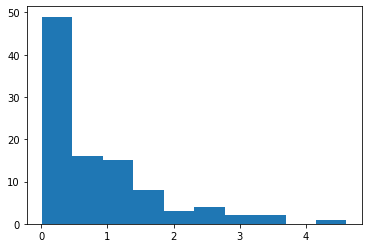

In [312]:
plt.hist(spp['alpha'])

In [313]:
#spp['tau']

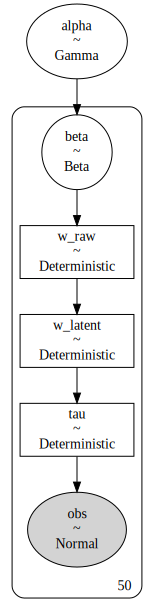

In [314]:
pm.model_to_graphviz(dpp_model)

In [315]:
with dpp_model:
    dpp_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [316]:
# with dpp_model:
#     pm.forestplot(dpp_trace);

In [317]:
dpp_ppc = pm.sample_posterior_predictive(dpp_trace, samples = 200, model = dpp_model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [318]:
dpp_ppc['obs'].mean(axis=0)

array([ 33.52835144,  69.69127341,  92.51193565,  95.66585645,
        98.31341551,  99.14723121,  99.41969826, 100.27463471,
        98.38091567,  99.35313654,  99.83506264, 100.62229203,
       100.73666989, 101.05849375,  99.48837906, 101.22734547,
        99.78505224, 100.10405542,  99.2995331 ,  99.37823568,
       101.06346059, 100.72609248,  99.9854563 , 100.65072518,
        99.76010445, 100.35005251, 100.45300435, 100.69605203,
       100.69744399, 100.8288727 ,  99.7722265 , 100.39872103,
        99.11985828, 101.60905046, 100.03640269, 100.59620553,
       100.57893921, 100.92553233,  99.90619421,  99.2465964 ,
        99.92666435,  99.65979457, 100.02785481,  98.4932685 ,
       100.26532482,  99.71775973, 100.32658741, 100.74015655,
        99.66897032,  99.88605638])

In [319]:
fin_changes

array([ 33,  66,  99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

Text(0, 0.5, 'Inference')

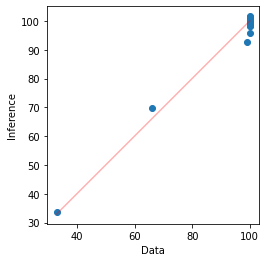

In [320]:
plt.scatter(fin_changes, dpp_ppc['obs'].mean(axis=0))
plt.gca().set_aspect('equal')
plt.plot([fin_changes[0],fin_changes[-1]],[fin_changes[0],fin_changes[-1]], color = 'red', alpha = 0.3)
plt.xlabel('Data')
plt.ylabel('Inference')